In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout
import math
# np.random.seed(0)

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
file2 = '../data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))

# shuffle = [x for x in range(len(data.values)) if x%2 == 0]
# comp = [x for x in range(len(data.values)) if x%2 ==1]
# shuffle.extend(comp)
shuffle = [0,1,2,3,4,5,6,7,8,30,28,26,24,22,20,9,10,12,14,16,18,29,27,25,23,21,19,17,15,13,11]

nsize = len(syscov)
# print(data.head(31))
# data.head(31) 
# plt.savefig("DistbinnedJLA.png")
np.shape(syscov)

errors = np.diag(syscov).reshape(nsize,1)
errors = np.where(errors!= 0, np.log(errors), 0)

z = data.values[:,0][shuffle]
dl = data.values[:,1][shuffle]

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]

# index = np.argsort(z)
zz = np.log(z)

# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))

# scalerdl = StandardScaler()
# scalerdl.fit(dl.reshape(-1, 1))
# dll = scalerdl.transform(dl.reshape((-1,1)))
dll = dl.reshape(nsize, 1)


# scalererr = StandardScaler()
# scalererr.fit(errors.reshape(-1, 1))
# errscl = scalererr.transform(errors.reshape((-1,1)))

z_train, z_test = np.split(zz, indx)
y = np.concatenate((dll, errors), axis=1)
y_train, y_test = np.split(y, indx)
# y


In [5]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
#     x = MCDropout(0.01)(efirst)
    x = Dense(100, activation='relu')(efirst)
    x = MCDropout(0.001)(x)

    elast = Dense(2, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,402
Trainable params: 5,402
Non-trainable params: 0
_________________________________________________________________


In [6]:
model2_train = neural_model2.fit(z_train, y_train, batch_size=1,
                                    epochs=300,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/300
24/24 [==============================] - 0s 10ms/step - loss: 731.1946 - val_loss: 757.9490
Epoch 2/300
24/24 [==============================] - 0s 1ms/step - loss: 712.4037 - val_loss: 706.4890
Epoch 3/300
24/24 [==============================] - 0s 1ms/step - loss: 667.3033 - val_loss: 612.0546
Epoch 4/300
24/24 [==============================] - 0s 1ms/step - loss: 593.4655 - val_loss: 466.6807
Epoch 5/300
24/24 [==============================] - 0s 1ms/step - loss: 465.0921 - val_loss: 293.9633
Epoch 6/300
24/24 [==============================] - 0s 1ms/step - loss: 355.6361 - val_loss: 176.6514
Epoch 7/300
24/24 [==============================] - 0s 1ms/step - loss: 150.1329 - val_loss: 138.3291
Epoch 8/300
24/24 [==============================] - 0s 1ms/step - loss: 205.3765 - val_loss: 123.3923
Epoch 9/300
24/24 [==============================] - 0s 1ms/step - loss: 171.5704 - val_loss: 112.8593
Epoch 10/300
24/24 [==============================] - 0s 1ms/step - loss

24/24 [==============================] - 0s 1ms/step - loss: 0.2826 - val_loss: 0.9159
Epoch 83/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4112 - val_loss: 0.9781
Epoch 84/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3033 - val_loss: 0.9432
Epoch 85/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3480 - val_loss: 1.0126
Epoch 86/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2603 - val_loss: 0.8277
Epoch 87/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2670 - val_loss: 1.0127
Epoch 88/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2229 - val_loss: 0.9643
Epoch 89/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1995 - val_loss: 0.9108
Epoch 90/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3670 - val_loss: 1.0643
Epoch 91/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2143 - val_loss: 0.9296
Epoch 92/300


Epoch 163/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1926 - val_loss: 1.2975
Epoch 164/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2243 - val_loss: 1.1578
Epoch 165/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1387 - val_loss: 1.1670
Epoch 166/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1187 - val_loss: 1.3850
Epoch 167/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1099 - val_loss: 1.1103
Epoch 168/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1767 - val_loss: 1.5665
Epoch 169/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2837 - val_loss: 1.3018
Epoch 170/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1341 - val_loss: 1.3289
Epoch 171/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 1.2997
Epoch 172/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1497 - val_los

24/24 [==============================] - 0s 1ms/step - loss: 0.1580 - val_loss: 1.3273
Epoch 245/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2984 - val_loss: 1.5518
Epoch 246/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1679 - val_loss: 1.3802
Epoch 247/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2670 - val_loss: 1.3358
Epoch 248/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1596 - val_loss: 1.6282
Epoch 249/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2159 - val_loss: 1.6559
Epoch 250/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1908 - val_loss: 1.1719
Epoch 251/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1973 - val_loss: 1.6192
Epoch 252/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3334 - val_loss: 1.4192
Epoch 253/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4771 - val_loss: 1.5162
Epoc

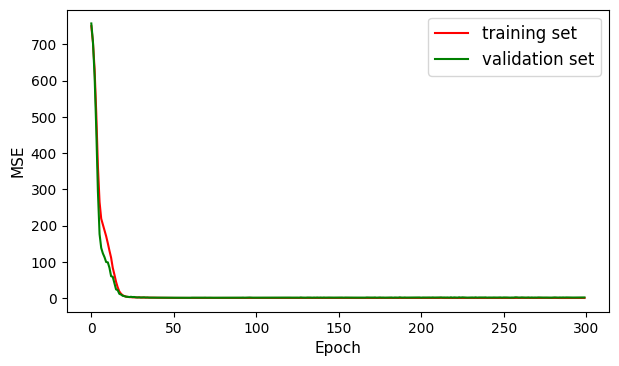

In [7]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('FFNN+MC-DO', fontsize=8)

plt.savefig('loss_dropoutJLA2.png')

In [8]:
file3 = 'fake_binned_JLA2TEST3new.dat'
data3 = np.loadtxt(file3, skiprows=3)

z_test = data3[:,0]
x_test = np.log(z_test)
# x_test = zz
z_test

array([0.00894169, 0.01070325, 0.01277511, 0.01521195, 0.01807804,
       0.02144902, 0.02541381, 0.03007702, 0.03556168, 0.0420125 ,
       0.04959966, 0.05852335, 0.06901899, 0.0813635 , 0.09588256,
       0.11295924, 0.13304406, 0.15666695, 0.18445113, 0.21712966,
       0.25556469, 0.30077026, 0.35393906, 0.41647383, 0.49002445,
       0.57653142, 0.67827708, 0.79794581, 0.93869486, 1.10423763,
       1.29894169])

In [9]:
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))

for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(x_test)
    

prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

# get mean results and its varience
predictions_dl = prediction_mc_dropout[:,0]
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))
predictions_err = np.exp(prediction_mc_dropout[:,1].reshape(-1,1))
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))


sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

np.shape(predictions), np.shape(predictions_dl), np.shape(predictions_err), np.shape(prediction_mc_dropout)


((100, 31, 2), (31,), (31, 1), (31, 2))

In [10]:
np.shape(prediction_mc_dropout), np.shape(predictions_dl), np.shape(predictions_err)
# predictions_err

((31, 2), (31,), (31, 1))

In [11]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [12]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

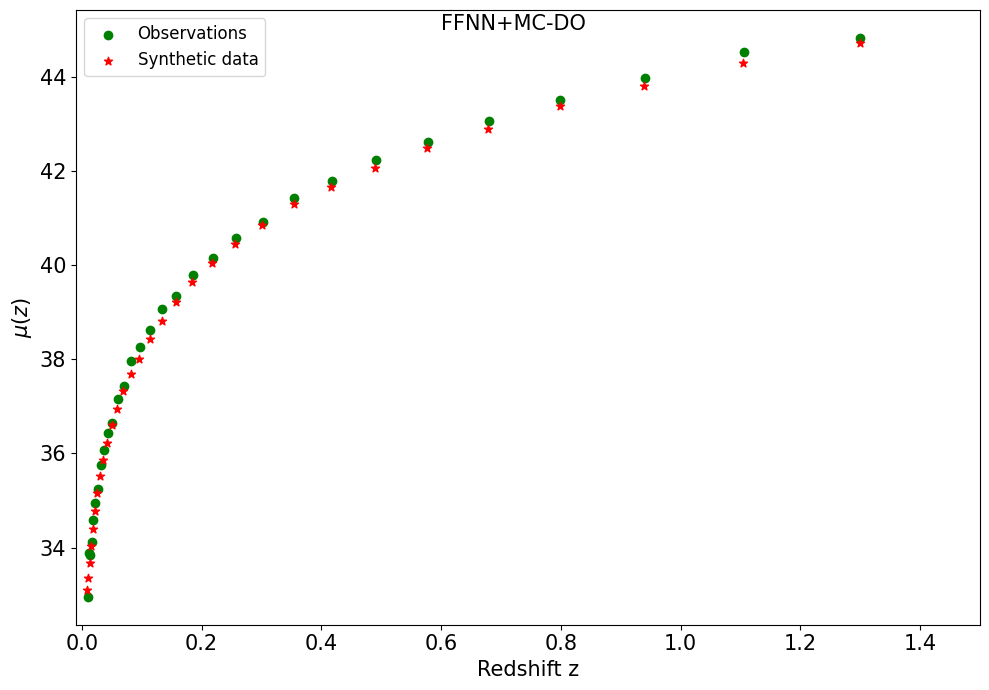

In [13]:
# Plotting
# dlfake = scalerdl.inverse_transform(prediction_mc_dropout[:,0].reshape(-1,1))
# dlfake = prediction_mc_dropout[:,0]
plt.figure(figsize=(10, 7), dpi=100)
x_test = np.exp(x_test)
# print(np.shape(dlfake))

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(x_test, predictions_dl, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.legend(loc='upper left', fontsize=12)
# plt.show()
plt.savefig('DL_dropoutb2.png')

In [14]:
index = np.argsort(z_test)
dlfake = predictions_dl
fake_data2 = np.stack((z_test[index], dlfake.reshape(31,)[index]), axis=1)


np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')
# np.savetxt("errors_JLA_DO.dat", predictions_err, delimiter= " ", header="#fake statistical errors", fmt='%1.9f')

In [15]:
tf.keras.models.save_model(neural_model2, '..models/FFNN_JLA_DO.h5' )